<a href="https://colab.research.google.com/github/lewisevans38/Suez-Time-Series-Anomaly-Detection-/blob/main/LSTMAEonNAB_ambientD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Base code taken from
 https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

 Modified where appropriate so that the code works for the NAB dataset and shows fit/ reconstruction error and detects anomalies.

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from matplotlib import pyplot as plt
import math
from copy import deepcopy
from sklearn.model_selection import train_test_split


In [ ]:
#Non anomalous
URL1 = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv"
DATA1 = pd.read_csv(URL1).set_index('timestamp')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = DATA1
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(-1,1))
scaler = scaler.fit(train[['value']])
train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])
df['value'] = scaler.transform(df[['value']])



(5813, 1) (1454, 1)


<ipython-input-14-0d285568ce3f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-14-0d285568ce3f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [ ]:
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 6
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['value']],
  train.value,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['value']],
  test.value,
  TIME_STEPS
)
print(X_train.shape)

##Turn into pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_train.shape)

(5808, 5, 1)
torch.Size([5808, 5, 1])


In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model = RecurrentAutoencoder(TIME_STEPS, 1, 64)
model = model.to(device)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = deepcopy(model.state_dict())
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  X_train,
  X_test,
  n_epochs=60
)

Epoch 1: train loss 0.5374505200484875 val loss 0.6897450297700692
Epoch 2: train loss 0.24982152827380394 val loss 0.44284921269054
Epoch 3: train loss 0.18888486910594715 val loss 0.2955946032706008
Epoch 4: train loss 0.14589759579193573 val loss 0.5047348898040417
Epoch 5: train loss 0.1170536779161009 val loss 0.16435834336087488
Epoch 6: train loss 0.09604333468200382 val loss 0.1958866328144995
Epoch 7: train loss 0.08663437897631303 val loss 0.3493231931113843
Epoch 8: train loss 0.0787204454844425 val loss 0.14825423254153908
Epoch 9: train loss 0.07610222589421489 val loss 0.22895684672212338
Epoch 10: train loss 0.07658637718928685 val loss 0.23377150946455508
Epoch 11: train loss 0.07093929596849494 val loss 0.13878911814868986
Epoch 12: train loss 0.07107020185764215 val loss 0.10088664673788125
Epoch 13: train loss 0.06674792922355911 val loss 0.1670780776645744
Epoch 14: train loss 0.05994780897154837 val loss 0.11709264885400228
Epoch 15: train loss 0.06136872649280042 

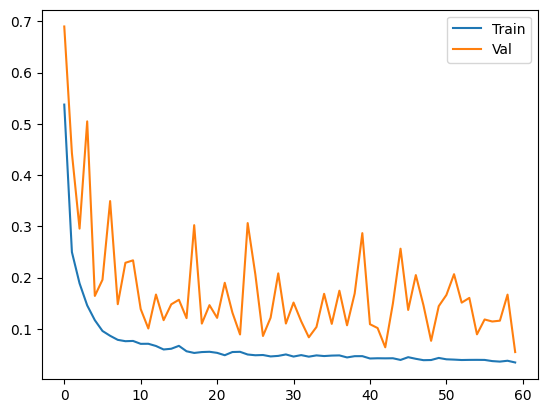

In [ ]:

plt.plot(history['train'], label = 'Train')
plt.plot(history['val'], label ='Val')
plt.legend()
plt.show()

In [ ]:
predictions = []
model = model.eval().to('cpu')
with torch.no_grad():
  for seq_true in X_train:

    seq_true = seq_true
    seq_pred = model(seq_true)
    predictions.append(seq_pred[:][-1].item())
  for seq_true in X_test:

    seq_true = seq_true
    seq_pred = model(seq_true)
    predictions.append(seq_pred[:][-1].item())



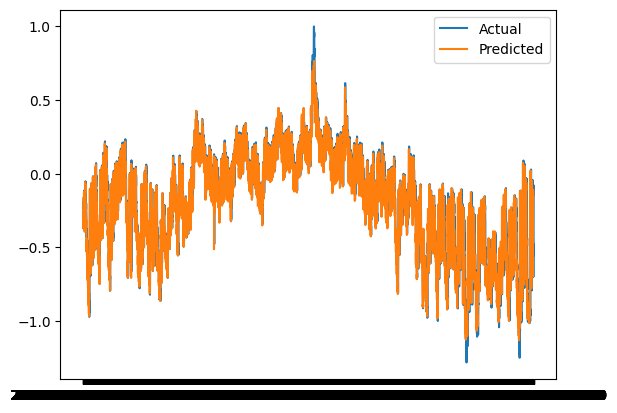

In [ ]:

plt.plot(df['value'], label = 'Actual')
plt.plot(predictions, label ='Predicted')
plt.legend()
plt.show()

In [ ]:
indextracker = []
difference = []
for x in range(0,len(predictions)):
  diff = abs(df['value'][x] - predictions[x])
  difference.append(diff)
standard_deviation = np.std(difference)
Mean = np.mean(difference)
for x in range (0,len(difference)):
 if difference[x] >3*standard_deviation+ Mean:
    indextracker.append(x)
print("The anomalous points are at" , indextracker)
print("The total amount of anomalies is", len(indextracker))

The anomalous points are at [776, 780, 2111, 2115, 5875, 5876, 5878, 5879, 5894, 5895, 5918, 6037, 6038, 6039, 6040, 6041, 6052, 6062, 6063, 6118, 6119, 6121, 6128, 6129, 6130, 6131, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6214, 6224, 6225, 6226, 6227, 6228, 6236, 6237, 6239, 6240, 6248, 6249, 6250, 6251, 6252, 6260, 6261, 6262, 6263, 6264, 6271, 6273, 6275, 6367, 6368, 6369, 6370, 6371, 6372, 6391, 6392, 6394, 6395, 6752, 6753, 6755, 6870, 6871, 6872, 6873, 6874, 6875, 6896, 6945, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7075, 7076, 7077, 7078, 7079, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7099, 7102, 7103, 7104, 7111, 7112, 7113, 7114, 7115, 7124, 7125, 7126, 7127, 7128, 7134, 7135, 7136, 7137, 7138, 7139, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7220, 7222, 7223, 7224, 7231, 7232, 7233, 7234, 7235, 7243, 7244, 7246, 7

In [ ]:
DATA2 = pd.read_csv(URL1)#.set_index('timestamp')
for x in range(0,len(indextracker)):
  print(DATA2.iloc[indextracker[x]]['timestamp'])

2013-08-06 21:00:00
2013-08-07 01:00:00
2013-10-16 23:00:00
2013-10-17 03:00:00
2014-03-24 02:00:00
2014-03-24 03:00:00
2014-03-24 19:00:00
2014-03-24 20:00:00
2014-03-25 11:00:00
2014-03-25 12:00:00
2014-03-26 11:00:00
2014-03-31 10:00:00
2014-03-31 11:00:00
2014-03-31 12:00:00
2014-03-31 13:00:00
2014-03-31 14:00:00
2014-04-01 01:00:00
2014-04-01 11:00:00
2014-04-01 12:00:00
2014-04-11 00:00:00
2014-04-11 01:00:00
2014-04-11 03:00:00
2014-04-11 10:00:00
2014-04-11 11:00:00
2014-04-11 12:00:00
2014-04-11 13:00:00
2014-04-14 09:00:00
2014-04-14 10:00:00
2014-04-14 11:00:00
2014-04-14 12:00:00
2014-04-14 13:00:00
2014-04-14 14:00:00
2014-04-14 15:00:00
2014-04-15 00:00:00
2014-04-15 10:00:00
2014-04-15 11:00:00
2014-04-15 12:00:00
2014-04-15 13:00:00
2014-04-15 14:00:00
2014-04-15 22:00:00
2014-04-15 23:00:00
2014-04-16 01:00:00
2014-04-16 02:00:00
2014-04-16 10:00:00
2014-04-16 11:00:00
2014-04-16 12:00:00
2014-04-16 13:00:00
2014-04-16 14:00:00
2014-04-16 22:00:00
2014-04-16 23:00:00


 "2013-12-22 20:00:00",

"2014-04-13 09:00:00"
